# FAIRshake Evaluation Summary

In [2]:
print("Created by Brian Schilder, 07/22/2018\n")
import sys
print("Python Version Info:")
print(sys.version)


Created by Brian Schilder, 07/22/2018

Python Version Info:
3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary Questions
- Average score for each question
- Standard deviation for each answer
- Correlation between questions
- Evals per person, max evals, and distribution
- Are some people generally harsher
- Which answers tended to have comments
- FAIRest tools vs. Least FAIR tools

## FAIRshake Questions
1. DESCRIPTION : The tool has a unique name and an informative description.
2. DOWNLOAD : The tool can be freely downloaded or accessed from a webpage.
3. ONTOLOGY : The tool utilizes a community-accepted ontology.
4. TUTORIAL : Tutorials for the tool are available on the tool‚Äôs homepage.
5. SOURCE CODE : Source code is shared in a public repository and is documented.
6. VERSIONING : Previous versions of the tool are made available.
7. CONTACT: Contact information is provided for the creator(s) of the tool and information describing how to cite the tool is provided.
8. API : The tool can be accessed programmatically through an API and follows community standards for open APIs.
9. LICENSE : Licensing information is provided on the tool's homepage.


In [3]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd
fair = pd.read_csv("merged_FAIRshake_evals.csv", index_col=None)
fair['q_id'] = pd.Categorical(fair['q_id'])
fair.shape
fair.columns

qDict = {1:'1. Description', 2:'2. Download', 3:'3. Ontology', 4:'4. Tutorial', 
         5:'5. Source Code', 6:'6. Versioning', 7:'7. Contact', 8:'8. API', 9:'9. License'}
fair["q_name"] = fair['q_id'].map(qDict)


## Average score for each question

In [4]:
import seaborn as sn
sn.set(font_scale=1.5)
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6) 

fair.answer.unique()
fair["answer01"] = fair.answer.map(dict(yes=1, no=0, yesbut=.75, nobut=.25))
avg_per_q = fair.groupby('q_name')['q_name','answer01'].mean()
std_per_q = fair.groupby('q_name')['q_name','answer01'].std()
avg_per_q.rename(columns={'answer01':'answer01_mean'}, inplace=True)
avg_per_q = avg_per_q.sort_values(by='answer01_mean', ascending=False)

# plot
# fair = fair.merge(avg_per_q, on='q_id')
g = sn.barplot(data=fair, x='q_name', y='answer01', order=avg_per_q.index)
# ax = sn.violinplot(data=fair, x='q_id', y='answer01', order=avg_per_q.index)
g.set(ylabel='Answer \n(yes=1, yesbut=.75, nobut=.25, no=0)', xlabel='Question ID', title="Average answer for each question")
plt.xticks(rotation=45, ha='center')
plt.show()



<Figure size 900x600 with 1 Axes>

## Frequency of each of the 4 score options for each question

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

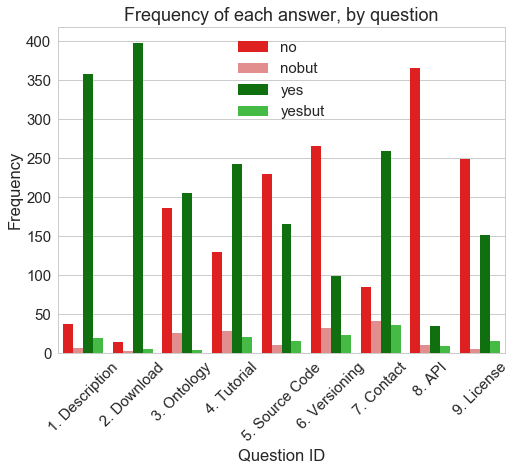

In [5]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

scores4 = fair.groupby(['q_name','answer'])['answer'].count()
scores4.name = 'answerCount'
scores4 = scores4.reset_index()
palette ={"no":"red","nobut":"lightcoral", "yes":"green", "yesbut":"limegreen"}
g = sn.barplot(data=scores4, x='q_name', y='answerCount', hue='answer', palette=palette)
g.set(ylabel='Frequency', xlabel='Question ID', title="Frequency of each answer, by question")
g.legend()
plt.xticks(rotation=45, ha='center')

## Correlations between questions

There is some correlation between q1 (Description) and q2 (Download).


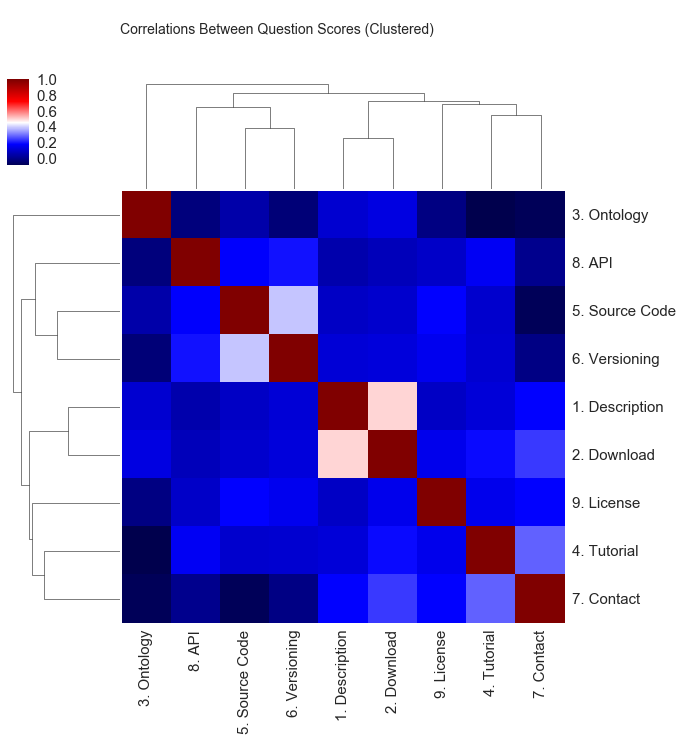

In [6]:
# fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

corrDict={}
for q in fair['q_name']:
    sub = fair.loc[fair['q_name']==q]['answer01']
    corrDict[q] = sub.values
corrMatrix = pd.DataFrame(corrDict).corr()

# g = sn.heatmap(corrMatrix, annot=True, cmap='seismic')
g = sn.clustermap(data=corrMatrix, cmap='seismic').fig.suptitle('\nCorrelations Between Question Scores (Clustered)', size=14) 
# g.set(ylabel='Question ID', xlabel='Question ID', title="Correlations between all questions")

print("There is some correlation between q1 (Description) and q2 (Download).")


## Evaluations Per Person

[Text(0,0.5,'Frequency'),
 Text(0.5,0,'Number of Evaluations'),
 Text(0.5,1,'Evaluations/person\n Mean = 20.05  \n Max = 100')]

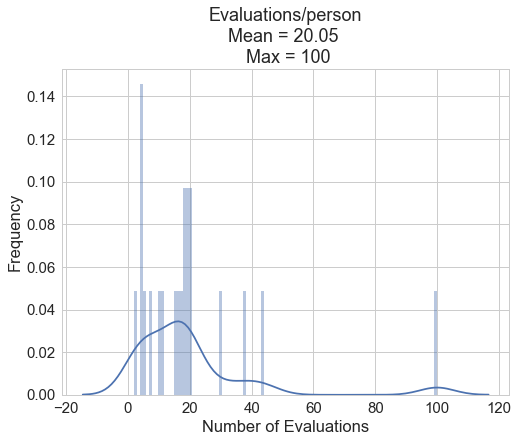

In [7]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

evalCounts = [len(x) for x in fair.groupby('user_id')['resource_name'].unique()]
avgCounts = sum(evalCounts)/len(evalCounts)


g = sn.distplot(evalCounts, bins=100)
g.set(xlabel='Number of Evaluations', ylabel='Frequency', 
       title="Evaluations/person\n Mean = "+str(round(avgCounts,2))+"  \n Max = "+str(max(evalCounts)))


## Are some raters harsher than others?

Evaluators gave a average FAIR score of 0.58 (on a 0-1 scale).


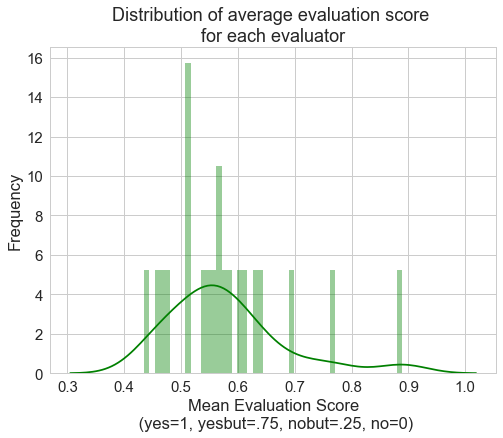

In [8]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

avgRating = fair.groupby('user_id')['user_id','answer01'].mean()
meanMean = avgRating['answer01'].mean()
g = sn.distplot(avgRating['answer01'], bins=50, color='green')
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Frequency', 
       title="Distribution of average evaluation score \nfor each evaluator")

print("Evaluators gave a average FAIR score of "+str(round(meanMean,2)) + " (on a 0-1 scale).")

## Which answers tended to have the most comments

Questions 1. Description and 7. Contact most frequently had comments.


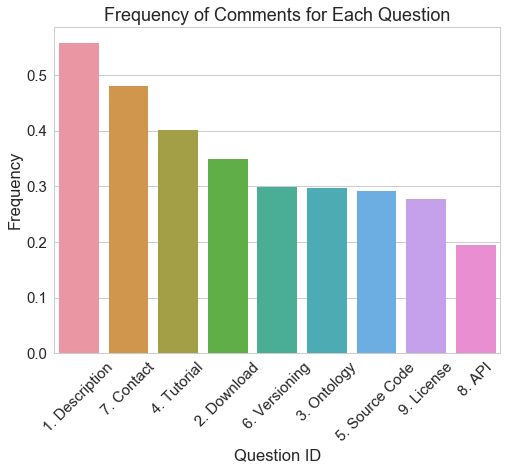

In [9]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

commentDict={}
for q in fair['q_name'].unique():
    sub = fair.loc[fair['q_name']==q]['comment']
    notEmpty = sum(~sub.isnull())/len(sub.isnull())
    commentDict[q] = notEmpty
commentDF = pd.Series(commentDict).sort_values(ascending=False)

g = sn.barplot(x=commentDF.index, y=commentDF )
g.set(xlabel='Question ID', ylabel='Frequency', 
       title="Frequency of Comments for Each Question")
plt.xticks(rotation=45, ha='center')
print("Questions "+commentDF.index[0]+" and "+commentDF.index[1]+ " most frequently had comments.")


## The FAIRest of the them all

FAIRest resources (score = 1.0)
                   resource_name  answer01
0  Saccharomyces Genome Database       1.0
1                         Canvas       1.0
2                    HaploGrep 2       1.0


Least FAIR resources ( score = 0.0).
           resource_name  answer01
385           NetExplore       0.0
386                Ka-me       0.0
387               SpeeDB       0.0
388               Evoker       0.0
389               Mcheza       0.0
390      ConsensusPathDB       0.0
391                 PAIR       0.0
392                 gCUP       0.0
393  Bridging the scales       0.0
394           RepMaestro       0.0
395              MeMotif       0.0
396                  SVA       0.0


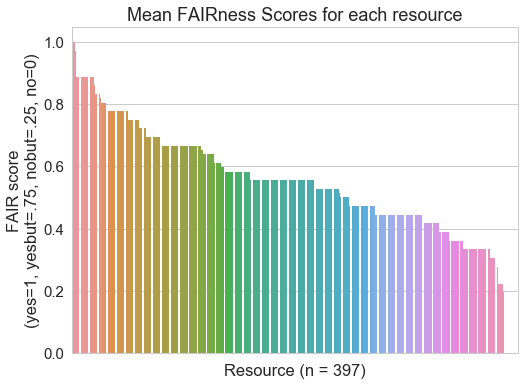

In [10]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==1,:]
leastFAIR  = resourceScores.loc[resourceScores['answer01']==0,:]

g = sn.barplot(data=resourceScores, x='resource_name', y='answer01')
g.set(xlabel='Resource (n = '+str(len(resourceScores))+')', ylabel='FAIR score\n(yes=1, yesbut=.75, nobut=.25, no=0)', 
       title="Mean FAIRness Scores for each resource")
g.set(xticklabels=[])

print("FAIRest resources (score = 1.0)")
print(FAIRest)
print("\n")
print("Least FAIR resources ( score = 0.0).")
print(leastFAIR)


## Time per Evaluation

In [11]:
import numpy as np
import time


# Import and format Time Stamp data (from Lily Wang)
timeData=[]
with open('fairshakejam-timestamp.txt') as f:
    flines = f.readlines() 
    import ast
    for line in flines:
        if line.startswith('{'):
            timeData.append(ast.literal_eval(line.strip('\n')))
len(timeData)
timeDF = pd.DataFrame(timeData) 
timeDF.head()
len(timeDF['ip'].unique()) 
print("Earliest timeStamp = "+timeDF['timestamp'][0])
print("Latest timeStamp = "+timeDF['timestamp'].iloc[-2])


# Conditionally add new col values
conditions = [ 
    (timeDF['req'].str.split(' ').str[-1].str.startswith('/newevaluation')),
    (timeDF['req'].str.split(' ').str[-1].str.startswith('/evaluationsubmitted'))
]
choices = ['evalStart','evalEnd']
timeDF['marker'] = np.select(conditions, choices, default='')
# Parse resource ID
timeDF['resourceID'] = timeDF[timeDF['req'].str.contains('resourceid=')]['req'].str.split('resourceid=').str[-1]

print('Processing eval times')
evalLengths={}
# Loop through each person
for ip in timeDF['ip'].unique():
    # print("Processing ip - "+ip)
    sub = timeDF.loc[timeDF['ip']==ip]
    sub['resourceID'] = sub['resourceID'].fillna(method='ffill')
    for resource in sub['resourceID'].unique():
        rsub = sub.loc[sub['resourceID']==resource]
        evalStart = rsub[rsub['marker']=='evalStart']['timestamp'].values
        evalEnd = rsub[rsub['marker'] =='evalEnd']['timestamp'].values  
        # evalStart = ['20/Jul/2018:14:13:33 +0000'] 
        # evalEnd = ['20/Jul/2018:14:18:46 +0000']
        if len(evalStart)!=0 and len(evalEnd)!=0:
            # only get timestamps that start with day
            evalStart = [item for item in evalStart if item[0].isdigit()]
            evalEnd = [item for item in evalEnd if item[0].isdigit()]
            # Convert to time_struct
            timeStart = time.strptime(evalStart[0], '%d/%b/%Y:%H:%M:%S +%f')
            timeEnd = time.strptime(evalEnd[0], '%d/%b/%Y:%H:%M:%S +%f') 
            timeLength = (time.mktime(timeEnd) - time.mktime(timeStart)) / 60 # Return difference in minutes
            # Symbol translation at:  http://strftime.org/
            evalLengths[resource] = timeLength
len(evalLengths)
# Save file to csv
timeDF.to_csv('fairshakejam-timestamp_processed.csv')

Earliest timeStamp = 19/Jul/2018:14:18:54 +0000
Latest timeStamp = 23/Jul/2018:20:07:44 +0000
Processing eval times


Mean evaluation time = 28.48 minutes.
Mode evaluation time = 1.05 minutes.
Median evaluation time = 3.55 minutes.
Min evaluation time = 8.0 seconds.
Max evaluation time = 21.71 hours.


[Text(0,0.5,'Frequency'),
 Text(0.5,0,'log( Evaluation Length (minutes) )'),
 Text(0.5,1,'Distribution of time per evaluation (logged)')]

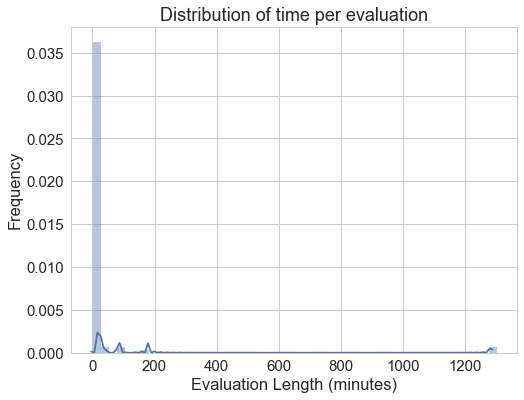

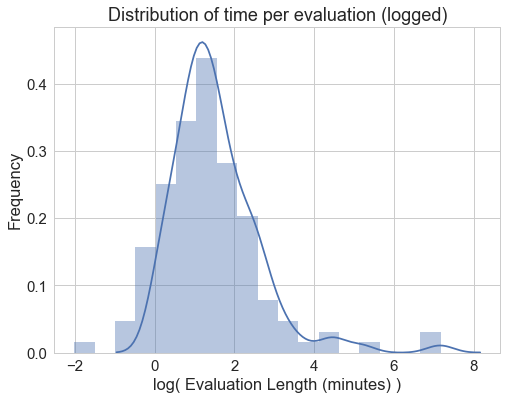

In [12]:
# Report summary stats
avgEvalTime = sum(evalLengths.values()) / len(evalLengths.values())
evalLengthsDF = pd.Series(evalLengths, name='evalLength').reset_index().rename(columns={'index':'resourceID'})
lst = list(evalLengths.values())
mode  = max(set(lst), key=lst.count)
lst_sort = sorted(lst)
median = lst_sort[int((len(lst_sort)/2)) ]

print("Mean evaluation time = "+str(round(avgEvalTime,2))+" minutes.")
print("Mode evaluation time = "+str(mode)+" minutes.")
print("Median evaluation time = "+str(median)+" minutes.") 
print("Min evaluation time = "+str(round(min(evalLengths.values())*60,2))+" seconds.")            
print("Max evaluation time = "+str(round( max(evalLengths.values())/60,2))+" hours.") 


fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6) 
g = sn.distplot(evalLengthsDF['evalLength'], kde_kws={'clip': (0.0,  max(evalLengthsDF['evalLength']))} )
g.set(xlabel='Evaluation Length (minutes)', ylabel='Frequency', 
       title="Distribution of time per evaluation")

fig2, ax2 = plt.subplots(figsize=(8, 6)) #default figsize = (8,6) 
# Log values to see distribution better
g2 = sn.distplot( np.log( evalLengthsDF['evalLength']),  kde_kws={'clip': (0.0,  max(np.log( evalLengthsDF['evalLength'])))})
g2.set(xlabel='log( Evaluation Length (minutes) )', ylabel='Frequency', 
       title="Distribution of time per evaluation (logged)")
 